# Matching Exercise

In this exercise, we’ll be evaluating how getting a college degree impacts earnings in the US using matching.

# Data Setup

In [18]:
import pandas as pd
import numpy as np
import warnings
#warnings.filterwarnings('ignore')

df = pd.read_stata(
    "./data/cps_for_matching.dta"
)

df.head()

,index,annual_earnings,female,simplified_race,has_college,age,county,class94
0,151404,NaN,1,3.0,1,30,0-WV,"Private, For Profit"
1,123453,NaN,0,0.0,0,21,251-TX,"Private, For Profit"
2,187982,NaN,0,0.0,0,40,5-MA,"Self-Employed, Unincorporated"
3,122356,NaN,1,0.0,1,27,0-TN,"Private, Nonprofit"
4,210750,42900.0,1,0.0,0,52,0-IA,"Private, For Profit"


# Getting To Know Your Data
Before you start matching, it is important to examine your data to ensure that matching is feasible (you have some overlap the the features of people in the treated and untreated groups), and also that there is a reason to match: either you’re unsure about some of the functional forms at play, or your have some imbalance between the two groups.

## Exercise 1
Show the raw difference of annual_earnings between those with and without a college degree (has_college). Is the difference statistically significant?

In [19]:
df[df['annual_earnings'].isnull() == False].head()

,index,annual_earnings,female,simplified_race,has_college,age,county,class94
4,210750,42900.0,1,0.0,0,52,0-IA,"Private, For Profit"
5,14438,31200.0,0,2.0,0,34,0-NV,"Private, For Profit"
7,108334,20020.0,0,0.0,1,68,0-GA,"Private, For Profit"
8,249989,22859.2,0,0.0,0,46,0-VT,Government - Local
9,64886,73860.8,0,0.0,1,38,0-MT,"Private, For Profit"


In [20]:
from scipy.stats import ttest_ind

dfn = df[df['annual_earnings'].isnull() == False]

# Compare
college    =  dfn[dfn['has_college']==1 ]["annual_earnings"].mean()
nocollege =  dfn[dfn['has_college']==0]["annual_earnings"].mean()

t_test = ttest_ind(dfn[dfn['has_college']==1 ]["annual_earnings"],
                   dfn[dfn['has_college']==0]["annual_earnings"])

print("Annual earnings with college degree: {:.2f}".format(college))
print("Annual earnings without college degree: {:.2f}".format(nocollege))
print("Difference between genders : {:.2f}".format(college-nocollege))
print("P-value : {:.4f}".format(t_test[1]))

Annual earnings with college degree: 53024.16
Annual earnings without college degree: 38865.67
Difference between genders : 14158.50
P-value : 0.0000


**Answer:** The annual salary with a college degree is 53024 dollars, while the annual salary without a college degree is 38865. The difference is about 14158 dollars. According to the p-value of the t-test, the difference is significant. 

# Exercise 2
Next we can check for balance. Check the share of people in different racial groups who have college degrees. Are those differences statistically significant?

Does the distribution also look different across counties (I don’t need statistical significance for this)?

Does the data seem balanced?

In [21]:
import statsmodels.formula.api as smf

model = smf.ols('has_college ~ C(simplified_race)', df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            has_college   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     122.1
Date:                Mon, 01 Mar 2021   Prob (F-statistic):           7.74e-78
Time:                        07:01:01   Log-Likelihood:                -7675.0
No. Observations:               11150   AIC:                         1.536e+04
Df Residuals:                   11146   BIC:                         1.539e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.4382      0.006     79.420      0.000       0.427       0.449
C(simplified_race)[T.1.0]    -0.1206      0.016     -7.507      0.000      -0.152      -0.089
C(simplified_race)[T.2.0]    -0.2398      0.014    -17.682      0.000      -0.266      -0.213
C(simplified_race)[T.3.0]     0.0367      0.016      2.261      0.024       0.005       0.069
==============================================================================
Omnibus:                    46681.807   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1670.333
Skew:                           0.377   Prob(JB):                         0.00
Kurtosis:                       1.261   Cond. No.                         3.97
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
country_data_dic = {
    "college" : df.groupby(["county"])["has_college"].sum(),
    "total"   : df.groupby(["county"]).size()
}

df_share=pd.DataFrame(data=country_data_dic)

df_share["share"] = df_share.college/df_share.total

df_share.head(n=10)

,college,total,share
county,,,
0-AK,43,133,0.323308
0-AL,59,175,0.337143
0-AR,51,171,0.298246
0-AZ,5,7,0.714286
0-CA,87,220,0.395455
0-CO,51,89,0.573034
0-CT,16,33,0.484848
0-FL,40,102,0.392157
0-GA,90,207,0.434783


# Question :  
- Do we need provide T-Test for share difference between the 4 race group ?

**Answer:**  
- The college shares across different races are quite different, especially for race 2. Race 2's college rate is lower than three other race groups, and the p-value indicates that the difference is statistically significant.
- The college shares across the different countries are quite additional too. For example, the country of 0-AZ owns a pretty high college rate. 
- The data is not balanced for the two metrics.

# Exercise 3
One of the other advantages of matching is that even when you have balanced data, you don’t have to go through the process of testing out different functional forms to see what fits the data base.

In our last exercise, we looked at the relationship between gender and earnings “controlling for age”, where we just put in age as a linear control. Plot a non-linear regression of annual_earnings on age (if you’re using plotnine, use geom_smooth(method="lowess").

Does the relationship look linear?

Does this speak to why it’s nice to not have to think about functional forms with matching as much?

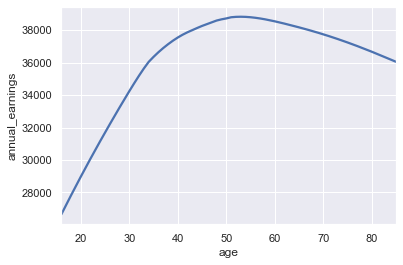

In [23]:
import seaborn as sns

#sns.set_theme(color_codes=True)
 
ax = sns.regplot(x="age", y="annual_earnings", data=dfn,
                 lowess=True, scatter=False)

**Answer:**
The relationship between age and annual_earnings is not linear. The plot explain why we'd better not to think about functional forms with matching.

# Matching!
Because DAME is an implementation of exact matching, we have to discretize all of our continuous variables. Thankfully, in this case we only have age, so this shouldn’t be too hard!

# Exercise 4
Create a new variable that discretizes age into a single value for each decade of age.

Because CPS only has employment data on people 18 or over, though, include people who are 18 or 19 with the 20 year olds so that group isn’t too small, and if you see any other really small groups, please merge those too.

In [24]:
df["age2"] = 2 
df["age2"] = np.array(df.age >= 30) + np.array(df.age2)
df["age2"] = np.array(df.age >= 40) + np.array(df.age2)
df["age2"] = np.array(df.age >= 50) + np.array(df.age2)
df["age2"] = np.array(df.age >= 60) + np.array(df.age2)
df.groupby(["age2"]).size()

age2
2    1990
3    2760
4    2551
5    2397
6    1452
dtype: int64

All the ages were discretizes into 5 bins whose lable means:
- 2: age < 30
- 3: age < 40
- 4: age < 50
- 5: age < 60
- 6: age >= 60

**Note**
- People whose age below 20 are combined with people younger than 30 to avoid too small groups. 
- For the same reason, people who are older than 60 were grouped without further division.

# Exercise 5
We also have to covert our string variables into numeric variables for DAME, so convert county and class94 to a numeric vector of intergers.

(Note: it’s not clear whether class94 belongs: if it reflects people choosing fields based on passion, it belongs; if people choose certain jobs because of their degrees, its not something we’d actually want in our regression.

Hint: if you use pd.Categorical to convert you var to a categorical, you can pull the underlying integer codes with .codes.

In [25]:
df["country_c"] = pd.Categorical(df.county).codes
df["class94_c"] = pd.Categorical(df.class94).codes

In [26]:
df.head()

,index,annual_earnings,female,simplified_race,has_college,age,county,class94,age2,country_c,class94_c
0,151404,NaN,1,3.0,1,30,0-WV,"Private, For Profit",3,47,3
1,123453,NaN,0,0.0,0,21,251-TX,"Private, For Profit",2,175,3
2,187982,NaN,0,0.0,0,40,5-MA,"Self-Employed, Unincorporated",4,226,6
3,122356,NaN,1,0.0,1,27,0-TN,"Private, Nonprofit",2,40,4
4,210750,42900.0,1,0.0,0,52,0-IA,"Private, For Profit",5,10,3


# Exercise 6
First, drop all the variables you don’t want in matching (e.g. your original age variable), and any observations for which annual_earnings is missing.

You will probably also have to drop a column named index: DAME will try and match on ANY included variables, and so because there was a column called index in the data we imported, if we leave it in DAME will try (and obviously fail) to match on index.

Also, it’s best to reset your index, as dame_flame using index labels to identify matches.

In [27]:
df_dame = df[["annual_earnings", 
              "female", 
              "simplified_race", 
              "has_college", 
              "age2", 
              "country_c", 
              "class94_c"]]

df_dame = df_dame[df_dame.annual_earnings.isnull() == False]
df_dame.reset_index(drop=True, inplace=True)
df_dame.head()

,annual_earnings,female,simplified_race,has_college,age2,country_c,class94_c
0,42900.0,1,0.0,0,5,10,3
1,31200.0,0,2.0,0,3,31,3
2,20020.0,0,0.0,1,6,8,3
3,22859.2,0,0.0,0,4,44,1
4,73860.8,0,0.0,1,3,24,3


# Exercise 7
The syntax of dame_flame is similar to the syntax of sklearn. If you start with a dataset called my_data with a treat variable with treatment assignment and an outcome variable for my outcome of interest (Y), the syntax to do basic matching would be:

```
import dame_flame
model = dame_flame.matching.DAME(repeats=False, verbose=3, want_pe=True)
model.fit(
    my_data,
    treatment_column_name="treat",
    outcome_column_name="outcome",
)
result = model.predict(my_data)
```

Where the arguments:

- repeats=False says that I want to do 1:1 matching (each observation is only paired once). We’ll talke about what happens if we use - - repeats=True below.

- verbose=3 tells dame to report everything it’s doing as it goes.

- want_pe says “please include the predictive error in your printout at each step”. This is a measure of match quality.

So run DAME on your data!

In [28]:
import dame_flame
model = dame_flame.matching.DAME(repeats=False, verbose=3, want_pe=True)
model.fit(
    df_dame,
    treatment_column_name="has_college",
    outcome_column_name="annual_earnings",
)
result = model.predict(df_dame)

Iteration number:  1
	Number of matched groups formed in total:  376
	Unmatched treated units:  636 out of a total of  1150 treated units
	Unmatched control units:  3174 out of a total of  4365 control units
	Predictive error of covariates chosen this iteration:  0
	Number of matches made in this iteration:  1705
	Number of matches made so far:  1705
	In this iteration, the covariates dropped are:  set()
Iteration number:  2
	Number of matched groups formed in total:  498
	Unmatched treated units:  22 out of a total of  1150 treated units
	Unmatched control units:  141 out of a total of  4365 control units
	Predictive error of covariates chosen this iteration:  1198668391.3274183
	Number of matches made in this iteration:  3647
	Number of matches made so far:  5352
	In this iteration, the covariates dropped are:  frozenset({'country_c'})
Iteration number:  3
	Number of matched groups formed in total:  498
	Unmatched treated units:  22 out of a total of  1150 treated units
	Unmatched co

# Exercise 8
Congratulations! You just on your first one-to-one matching!

The next step is to think about which of the matches that DAME generated are good enough for inclusion in our analysis. As you may recall, one of the choices you have to make as a researcher when doing matching is how “good” a match has to be in order to be included in your final data set. By default, DAME will keep dropping matching variables until it has been able to match all of the treated observations or runs out of variables. It will do this no matter how bad the matches start to become – if it ends up with the treated observation and a control observation that can only be matched on gender, it will match them just on gender, even though we probably don’t think that that’s a “good” match.

The way to control this behavior is to tell DAME when to stop manually using the early_stop_iterations argument to tell the matching algorithm when to stop.

So when is a good time to stop? There’s no objective or “right” answer to that question. It fundamentally comes down to a trade-off between bias (which gets higher is you allow more low quality matches into your data) and variance (which will go down as you increase the number of matches you keep).

But one way to start the process of picking a cutpoint is to examine how the quality of matches evolves over iterations. DAME keep this information in model.pe_each_iter. This shows, for each iteration, the “prediction error” resulting from dropping the variables excluded in each step. This “prediction error” is the difference in the mean-squared error of regressing Y on our matching variables (by default in a ridge regression) with all variables versus with the subset being used for matching in a given iteration. By design, of course, this is always increasing.

To see how this evolves, plot your pe against iteration numbers. Note that our first iteration doesn’t count, since by definition the first iteration has an error of 0, and also note that the iterations count from 1, not 0 (weird for Python… but whatever). You can also see the pe values for each iteration reported in the output from when DAME ran above if you want to make your you’re lining up the errors with iterations right.

Are there any points where the match quality seems to fall off dramatically?

In [29]:
len(model.pe_each_iter)

7

In [30]:
df_pe = pd.DataFrame({"pe": model.pe_each_iter, 
                      "iter":range(2, len(model.pe_each_iter)+2)})
df_pe

,pe,iter
0,1.198668e+09,2
1,1.203975e+09,3
2,1.203991e+09,4
3,1.204321e+09,5
4,1.204416e+09,6
5,1.209769e+09,7
6,1.209785e+09,8


Text(0.5, 1.0, 'PE against iteration numbers')

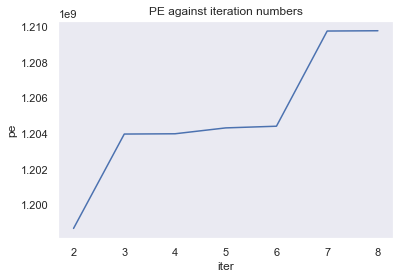

In [31]:
import matplotlib.pyplot as plt

sns.lineplot(data=df_pe, x="iter", y="pe")
plt.grid()
plt.title('PE against iteration numbers')

The pe value jumps twice along with the iteration growth from 2 to 8. The first jump occurs at from 2 to 3, and the second jump occurs at from 6 to 7. 

# Exercise 9
Suppose we want to ensure we have at least 5,000 observations in our data – where might you cut off the data to get a sample size of at least that but before a big quality falloff?

According to the log of exercise 7, the number of matches reached 5,000 observations in iteration 2. Since there is a big pe jump from iteration 2 to iteration 3, it's better to stop at iteration 2. 

# Exercise 10
Re-run your matching, stopping at the point you picked above using early_stop_iterations.

In [32]:
import dame_flame
model = dame_flame.matching.DAME(repeats=False, 
                                 verbose=3, 
                                 want_pe=True,
                                 early_stop_iterations=2)
model.fit(
    df_dame,
    treatment_column_name="has_college",
    outcome_column_name="annual_earnings",
)
result = model.predict(df_dame)

Iteration number:  1
	Number of matched groups formed in total:  376
	Unmatched treated units:  636 out of a total of  1150 treated units
	Unmatched control units:  3174 out of a total of  4365 control units
	Predictive error of covariates chosen this iteration:  0
	Number of matches made in this iteration:  1705
	Number of matches made so far:  1705
	In this iteration, the covariates dropped are:  set()
Iteration number:  2
	Number of matched groups formed in total:  498
	Unmatched treated units:  22 out of a total of  1150 treated units
	Unmatched control units:  141 out of a total of  4365 control units
	Predictive error of covariates chosen this iteration:  1198668391.3274183
	Number of matches made in this iteration:  3647
	Number of matches made so far:  5352
	In this iteration, the covariates dropped are:  frozenset({'country_c'})
5352 units matched. We stopped before doing iteration number:  2


# Exercise 11

Copy-paste that code and run it with your original data, your (fit) model, and what you got back when you ran result_of_fit. Then we’ll work with the output of that. You should get back a single dataframe of the same length as your original model. Note you’ll see a bunch of “Unit X does not have any matches” warnings – ignore those!

In [33]:
def get_dataframe(model, result_of_fit):

    # Get original data
    better = model.input_data.loc[result_of_fit.index]
    if not better.index.is_unique:
        raise ValueError("Need index values in input data to be unique")

    # Get match groups for clustering
    better["match_group"] = np.nan
    better["match_group_size"] = np.nan
    for idx, group in enumerate(model.units_per_group):
        better.loc[group, "match_group"] = idx
        better.loc[group, "match_group_size"] = len(group)

    # Get weights. I THINK this is right?! At least for with repeat=False?
    t = model.treatment_column_name
    better["t_in_group"] = better.groupby("match_group")[t].transform(np.sum)

    # Make weights
    better["weights"] = np.nan
    better.loc[better[t] == 1, "weights"] = 1  # treaments are 1

    # Controls start as proportional to num of treatments
    # each observation is matched to.
    better.loc[better[t] == 0, "weights"] = better["t_in_group"] / (
        better["match_group_size"] - better["t_in_group"]
    )

    # Then re-normalize for num unique control observations.
    control_weights = better[better[t] == 0]["weights"].sum()

    num_control_obs = len(better[better[t] == 0].index.drop_duplicates())
    renormalization = num_control_obs / control_weights
    better.loc[better[t] == 0, "weights"] = (
        better.loc[better[t] == 0, "weights"] * renormalization
    )
    assert better.weights.notnull().all()

    better = better.drop(["t_in_group"], axis="columns")

    # Make sure right length and values!
    assert len(result_of_fit) == len(better)
    assert better.loc[better[t] == 0, "weights"].sum() == num_control_obs

    return better

# Exercise 12
We previously tested balance on simplified_race, and by county. Check those again. Are there still statistically significant differences in college education by simplified_race?

Note that when you test for this, you’ll need to take into account the weights column you got back from get_dataframe. What DAME does is not actually the 1-to-1 matching described in our readings – instead, however many observations that exact match it finds it puts in the same “group”. (These groups are identified in the dataframe you got from get_dataframe by the column match_group, and the size of each group is in match_group_size.)

So to analyze the data, you need to use the wls (weighted least squares) function in statsmodels. For example, if your data is called matched_data, you might run:

```
smf.wls(
    "has_college ~ C(simplified_race)", matched_data, weights=matched_data["weights"]
).fit().summary()
```

In [34]:
matched_data = get_dataframe(model, result)
matched_data.head()

,annual_earnings,female,simplified_race,has_college,age2,country_c,class94_c,match_group,match_group_size,weights
0,42900.0,1,0.0,0,5,10,3,60.0,5.0,0.936170
1,31200.0,0,2.0,0,3,31,3,417.0,108.0,0.070654
2,20020.0,0,0.0,1,6,8,3,53.0,3.0,1.000000
3,22859.2,0,0.0,0,4,44,1,430.0,28.0,1.248227
4,73860.8,0,0.0,1,3,24,3,108.0,7.0,1.000000


In [35]:
smf.wls(
    "has_college ~ C(simplified_race)", matched_data, weights=matched_data["weights"]
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:            has_college   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                 4.553e-13
Date:                Mon, 01 Mar 2021   Prob (F-statistic):               1.00
Time:                        07:01:30   Log-Likelihood:                -3764.2
No. Observations:                5352   AIC:                             7536.
Df Residuals:                    5348   BIC:                             7563.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.2108      0.007     31.626      0.000       0.198       0.224
C(simplified_race)[T.1.0]  9.975e-17      0.018   5.53e-15      1.000      -0.035       0.035
C(simplified_race)[T.2.0]  1.301e-18      0.019   6.99e-17      1.000      -0.037       0.037
C(simplified_race)[T.3.0]  2.559e-17      0.020   1.27e-15      1.000      -0.040       0.040
==============================================================================
Omnibus:                      872.095   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1377.393
Skew:                           1.241   Prob(JB):                    8.00e-300
Kurtosis:                       2.871   Cond. No.                         3.95
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The weighted least squares show that college education differences by simplified_race are not statistically significant for all kinds of races. This result is quite different from the conclusion we got in the former question.

# Exercise 13
Now use a weighted least squares regression on your matched data to regress annual earnings on just having a college eduction. What is the apparent effect of a BA? How does that compare to our initial estimate using the raw CPS data (before matching)?

In [36]:
smf.wls(
    "annual_earnings ~ has_college", matched_data, weights=matched_data["weights"]
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:        annual_earnings   R-squared:                       0.058
Model:                            WLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     327.1
Date:                Mon, 01 Mar 2021   Prob (F-statistic):           5.26e-71
Time:                        07:01:32   Log-Likelihood:                -62236.
No. Observations:                5352   AIC:                         1.245e+05
Df Residuals:                    5350   BIC:                         1.245e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    3.914e+04    348.749    112.240      0.000    3.85e+04    3.98e+04
has_college  1.374e+04    759.654     18.085      0.000    1.22e+04    1.52e+04
==============================================================================
Omnibus:                     2955.825   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33660.552
Skew:                           2.419   Prob(JB):                         0.00
Kurtosis:                      14.294   Cond. No.                         2.58
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
import statsmodels.formula.api as smf

model = smf.ols('annual_earnings ~ has_college', df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        annual_earnings   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     370.2
Date:                Mon, 01 Mar 2021   Prob (F-statistic):           6.56e-80
Time:                        07:01:33   Log-Likelihood:                -63018.
No. Observations:                5515   AIC:                         1.260e+05
Df Residuals:                    5513   BIC:                         1.261e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    3.887e+04    336.007    115.669      0.000    3.82e+04    3.95e+04
has_college  1.416e+04    735.820     19.242      0.000    1.27e+04    1.56e+04
==============================================================================
Omnibus:                     2214.375   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10578.287
Skew:                           1.910   Prob(JB):                         0.00
Kurtosis:                       8.608   Cond. No.                         2.59
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The weighted least squares regression on matched data shows that a bachelor's degree has a statistically significant annual salary effect. Owning a bachelor's degree could boost annual salary by 13740 dollars. The boost effect given by WLS on matched data is lower than the boost effect given by OLS on raw CPS data.

# Exercise 14
Now include our other matching variables as controls. Does the coefficient change?

In [38]:
smf.wls(
    "annual_earnings ~ has_college + simplified_race + female + C(age2) + C(country_c) + C(class94_c)", 
        matched_data, weights=matched_data["weights"]
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:        annual_earnings   R-squared:                       0.242
Model:                            WLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     4.930
Date:                Mon, 01 Mar 2021   Prob (F-statistic):          3.50e-139
Time:                        07:01:35   Log-Likelihood:                -61653.
No. Observations:                5352   AIC:                         1.240e+05
Df Residuals:                    5025   BIC:                         1.261e+05
Df Model:                         326                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            6.087e+04   2870.058     21.207      0.000    5.52e+04    6.65e+04
C(age2)[T.3]         8417.6425    862.649      9.758      0.000    6726.473    1.01e+04
C(age2)[T.4]         1.177e+04    926.474     12.703      0.000    9952.697    1.36e+04
C(age2)[T.5]         1.224e+04    961.816     12.722      0.000    1.04e+04    1.41e+04
C(age2)[T.6]         9885.5829   1135.505      8.706      0.000    7659.497    1.21e+04
C(country_c)[T.1]     -1.1e+04   3219.227     -3.418      0.001   -1.73e+04   -4693.294
C(country_c)[T.2]   -1.343e+04   3213.607     -4.178      0.000   -1.97e+04   -7125.208
C(country_c)[T.3]   -9723.6374   1.18e+04     -0.826      0.409   -3.28e+04    1.34e+04
C(country_c)[T.4]   -7801.5974   2973.643     -2.624      0.009   -1.36e+04   -1971.960
C(country_c)[T.5]   -6259.3455   4112.947     -1.522      0.128   -1.43e+04    1803.824
C(country_c)[T.6]    -1.54e+04   1.04e+04     -1.480      0.139   -3.58e+04    4993.559
C(country_c)[T.7]   -1.061e+04   3750.077     -2.830      0.005    -1.8e+04   -3260.656
C(country_c)[T.8]   -1.342e+04   3133.394     -4.284      0.000   -1.96e+04   -7281.343
C(country_c)[T.9]   -1.358e+04   5092.703     -2.666      0.008   -2.36e+04   -3594.110
C(country_c)[T.10]  -1.447e+04   3442.943     -4.203      0.000   -2.12e+04   -7719.354
C(country_c)[T.11]  -1.362e+04   3021.611     -4.506      0.000   -1.95e+04   -7692.871
C(country_c)[T.12]  -8349.6343   3104.114     -2.690      0.007   -1.44e+04   -2264.217
C(country_c)[T.13]  -1.347e+04   3345.539     -4.025      0.000      -2e+04   -6907.163
C(country_c)[T.14]  -1.314e+04   3917.278     -3.354      0.001   -2.08e+04   -5458.791
C(country_c)[T.15]  -8477.9556   4782.435     -1.773      0.076   -1.79e+04     897.703
C(country_c)[T.16]  -1.155e+04   3593.918     -3.214      0.001   -1.86e+04   -4504.483
C(country_c)[T.17]   -1.62e+04   7691.759     -2.107      0.035   -3.13e+04   -1124.866
C(country_c)[T.18]    525.4876   4875.490      0.108      0.914   -9032.599    1.01e+04
C(country_c)[T.19]  -1.655e+04   6519.173     -2.539      0.011   -2.93e+04   -3770.711
C(country_c)[T.20]  -1.161e+04   4168.937     -2.784      0.005   -1.98e+04   -3435.448
C(country_c)[T.21]  -6251.4647   3577.992     -1.747      0.081   -1.33e+04     762.959
C(country_c)[T.22]  -1.754e+04   3651.220     -4.803      0.000   -2.47e+04   -1.04e+04
C(country_c)[T.23]  -1.576e+04   3199.142     -4.926      0.000    -2.2e+04   -9487.444
C(country_c)[T.24]  -1.183e+04   3153.685     -3.751      0.000    -1.8e+04   -5647.433
C(country_c)[T.25]  -1.733e+04   3445.810     -5.030      0.000   -2.41e+04   -1.06e+04
C(country_c)[T.26]  -1.396e+04   3116.985     -4.480      0.000   -2.01e+04   -7852.899
C(country_c)[T.27]  -1.319e+04   3321.505     -3.971      0.000   -1.97e+04   -6677.495
C(c

In this model, owning a college degree still has a statistically significant positive effect on an annual salary; however, the coefficient decrease from 14160 dollars to 13200 dollars.

# Exercise 15
If you stopped matching after Iteration 2 back in Exercise 10, you may be wondering if that was a good choice! Let’s check by restricting our attention to ONLY exact matches (iteration = 1). Run that match.

In [39]:
model = dame_flame.matching.DAME(repeats=False, 
                                 verbose=3, 
                                 want_pe=True,
                                 early_stop_iterations=1)
model.fit(
    df_dame,
    treatment_column_name="has_college",
    outcome_column_name="annual_earnings",
)
result = model.predict(df_dame)

Iteration number:  1
	Number of matched groups formed in total:  376
	Unmatched treated units:  636 out of a total of  1150 treated units
	Unmatched control units:  3174 out of a total of  4365 control units
	Predictive error of covariates chosen this iteration:  0
	Number of matches made in this iteration:  1705
	Number of matches made so far:  1705
	In this iteration, the covariates dropped are:  set()
1705 units matched. We stopped before doing iteration number:  1
